<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The Space Shuttle Reentry Problem Using JuMP
</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Space Shuttle Reentry Problem:* We aim find the optimal trajectory of a space shuttle reentry while minimizing the angle of attack at the terminal point.
The problem is inspired from Chapter 6 of: [Practical Methods for Optimal Control and Estimation Using Nonlinear Programming, Second Edition](https://epubs.siam.org/doi/book/10.1137/1.9780898718577).                             
We solve the problem using the [JuMP](https://jump.dev/) package in Julia with the rectangular integration method and the trapezoidal integration method.

1. [Trapzoidal Integration Method](#trap)
2. [Rectangular Integration Method](#rect)

</div>

*Remarks:*
* Picking a good linear solver is **extremely important** to maximize the performance of nonlinear solvers. For the best results, it is advised to experiment different linear solvers.

* We use the linear solver `HSl_MA57`.

* A modelization of the problem is provided by JuMP in this [tutorial](https://jump.dev/JuMP.jl/stable/tutorials/nonlinear/space_shuttle_reentry_trajectory/) but the function [`fix`](https://jump.dev/JuMP.jl/stable/api/JuMP/#fix) cause problems for the trapezoidal rule so we replaced it with a simple `constraint`.

> **Note:** The results given by the trapzoidal integration method are more accurate than the rectangular integration method. We have a difference of `0.04°` between the two methods.

## 1. Trapzoidal Integration Method <a id="trap"></a>

In [1]:
using JuMP , Ipopt
import HSL_jll
include("../Problems/JuMP/space_Shuttle_JMP.jl")
SpaceShuttleJMP = space_Shuttle_JMP("trapezoidal")

set_optimizer(SpaceShuttleJMP,Ipopt.Optimizer)
set_attribute(SpaceShuttleJMP, "hsllib", HSL_jll.libhsl_path)
set_attribute(SpaceShuttleJMP, "linear_solver", "ma57")

optimize!(SpaceShuttleJMP) 


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    33141
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   179214

Total number of variables............................:     4527
                     variables with only lower bounds:     1006
                variables with lower and upper bounds:     2515
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3021
Total number of inequality constrai

In [2]:
@assert is_solved_and_feasible(SpaceShuttleJMP)

# Show final cross-range of the solution
println(
    "Final latitude θ = ",
    round(objective_value(SpaceShuttleJMP) |> rad2deg; digits = 2),
    "°",
)

Final latitude θ = 34.14°


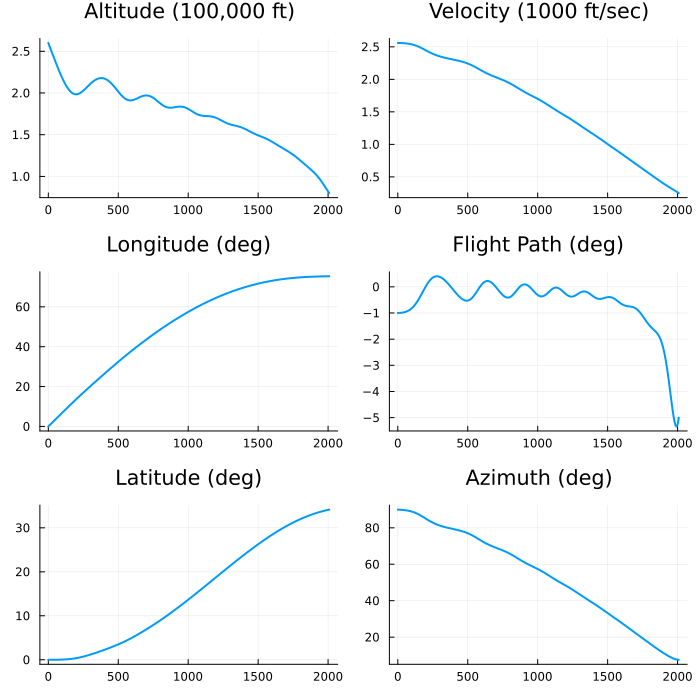

In [3]:
using Plots
n=503
scaled_h = SpaceShuttleJMP[:scaled_h]
scaled_v = SpaceShuttleJMP[:scaled_v]
ϕ = SpaceShuttleJMP[:ϕ]
θ = SpaceShuttleJMP[:θ]
γ = SpaceShuttleJMP[:γ]
ψ = SpaceShuttleJMP[:ψ]
Δt = SpaceShuttleJMP[:Δt]
ts = cumsum([0; value.(Δt)])[1:end-1]
plt_altitude = plot(
    ts,
    value.(scaled_h);
    legend = nothing,
    title = "Altitude (100,000 ft)",
)
plt_longitude =
    plot(ts, rad2deg.(value.(ϕ)); legend = nothing, title = "Longitude (deg)")
plt_latitude =
    plot(ts, rad2deg.(value.(θ)); legend = nothing, title = "Latitude (deg)")
plt_velocity = plot(
    ts,
    value.(scaled_v);
    legend = nothing,
    title = "Velocity (1000 ft/sec)",
)
plt_flight_path =
    plot(ts, rad2deg.(value.(γ)); legend = nothing, title = "Flight Path (deg)")
plt_azimuth =
    plot(ts, rad2deg.(value.(ψ)); legend = nothing, title = "Azimuth (deg)")

plot(
    plt_altitude,
    plt_velocity,
    plt_longitude,
    plt_flight_path,
    plt_latitude,
    plt_azimuth;
    layout = grid(3, 2),
    linewidth = 2,
    size = (700, 700),
)

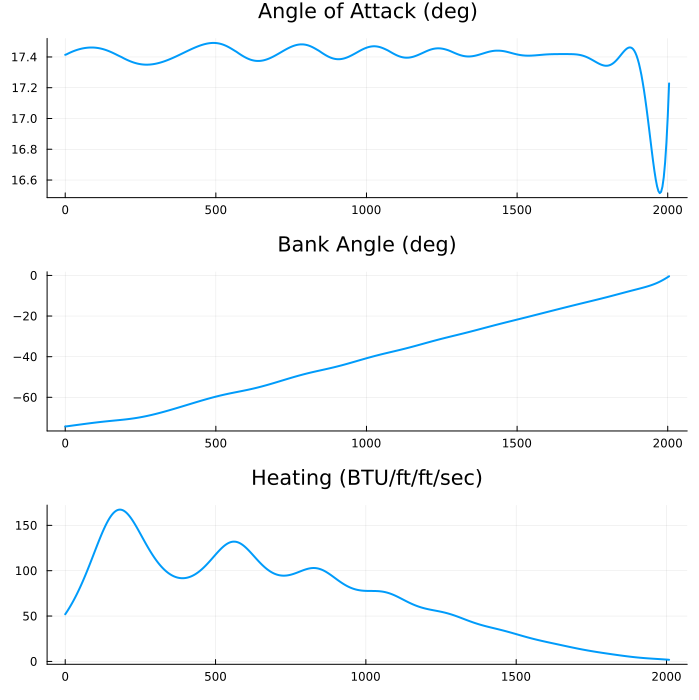

In [4]:
α = SpaceShuttleJMP[:α]
β = SpaceShuttleJMP[:β]
c₀ = 1.0672181
c₁ = -0.19213774e-1
c₂ = 0.21286289e-3
c₃ = -0.10117249e-5
ρ₀ = 0.002378
hᵣ = 23800.0
function q(h, v, a)
    ρ(h) = ρ₀ * exp(-h / hᵣ)
    qᵣ(h, v) = 17700 * √ρ(h) * (0.0001 * v)^3.07
    qₐ(a) = c₀ + c₁ * rad2deg(a) + c₂ * rad2deg(a)^2 + c₃ * rad2deg(a)^3
    # Aerodynamic heating on the vehicle wing leading edge
    return qₐ(a) * qᵣ(h, v)
end

plt_attack_angle = plot(
    ts[1:end-1],
    rad2deg.(value.(α)[1:end-1]);
    legend = nothing,
    title = "Angle of Attack (deg)",
)
plt_bank_angle = plot(
    ts[1:end-1],
    rad2deg.(value.(β)[1:end-1]);
    legend = nothing,
    title = "Bank Angle (deg)",
)
plt_heating = plot(
    ts,
    q.(value.(scaled_h) * 1e5, value.(scaled_v) * 1e4, value.(α));
    legend = nothing,
    title = "Heating (BTU/ft/ft/sec)",
)

plot(
    plt_attack_angle,
    plt_bank_angle,
    plt_heating;
    layout = grid(3, 1),
    linewidth = 2,
    size = (700, 700),
)

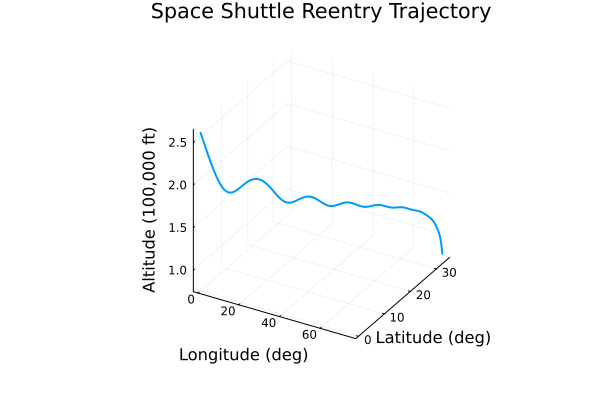

In [5]:
plot(
    rad2deg.(value.(ϕ)),
    rad2deg.(value.(θ)),
    value.(scaled_h);
    linewidth = 2,
    legend = nothing,
    title = "Space Shuttle Reentry Trajectory",
    xlabel = "Longitude (deg)",
    ylabel = "Latitude (deg)",
    zlabel = "Altitude (100,000 ft)",
)

## 2. Rectangular Integration Method <a id="rect"></a>

In [7]:
using JuMP , Ipopt
import HSL_jll
include("../Problems/JuMP/space_Shuttle_JMP.jl")
SpaceShuttleJMP = space_Shuttle_JMP()

set_optimizer(SpaceShuttleJMP,Ipopt.Optimizer)
set_attribute(SpaceShuttleJMP, "hsllib", HSL_jll.libhsl_path)
set_attribute(SpaceShuttleJMP, "linear_solver", "ma57")

optimize!(SpaceShuttleJMP)

This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    21093
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    57228

Total number of variables............................:     4527
                     variables with only lower bounds:     1006
                variables with lower and upper bounds:     2515
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3021
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.25e+03 1.10e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   

In [8]:
@assert is_solved_and_feasible(SpaceShuttleJMP)

# Show final cross-range of the solution
println(
    "Final latitude θ = ",
    round(objective_value(SpaceShuttleJMP) |> rad2deg; digits = 2),
    "°",
)

Final latitude θ = 34.18°


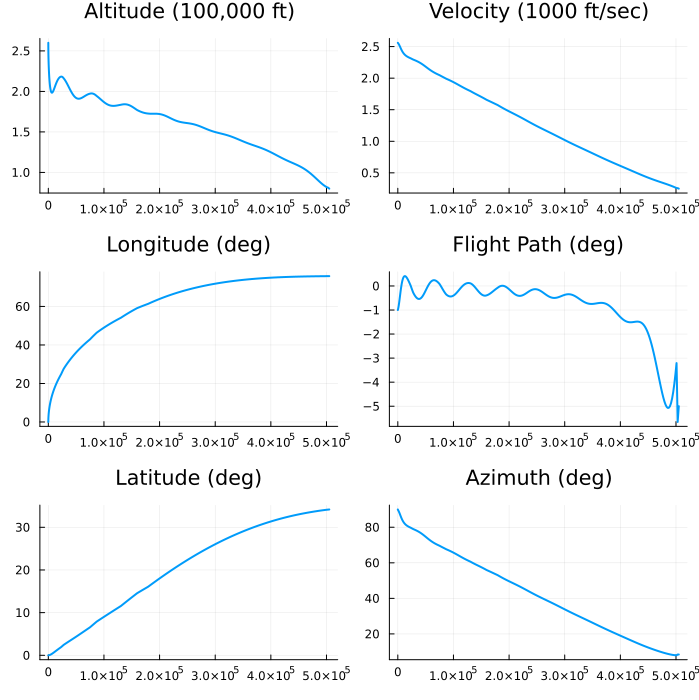

In [9]:
using Plots
n=503
scaled_h = SpaceShuttleJMP[:scaled_h]
scaled_v = SpaceShuttleJMP[:scaled_v]
ϕ = SpaceShuttleJMP[:ϕ]
θ = SpaceShuttleJMP[:θ]
γ = SpaceShuttleJMP[:γ]
ψ = SpaceShuttleJMP[:ψ]
Δt = 4.0 *(1:n)
ts = cumsum([0; value.(Δt)])[1:end-1]
plt_altitude = plot(
    ts,
    value.(scaled_h);
    legend = nothing,
    title = "Altitude (100,000 ft)",
)
plt_longitude =
    plot(ts, rad2deg.(value.(ϕ)); legend = nothing, title = "Longitude (deg)")
plt_latitude =
    plot(ts, rad2deg.(value.(θ)); legend = nothing, title = "Latitude (deg)")
plt_velocity = plot(
    ts,
    value.(scaled_v);
    legend = nothing,
    title = "Velocity (1000 ft/sec)",
)
plt_flight_path =
    plot(ts, rad2deg.(value.(γ)); legend = nothing, title = "Flight Path (deg)")
plt_azimuth =
    plot(ts, rad2deg.(value.(ψ)); legend = nothing, title = "Azimuth (deg)")

plot(
    plt_altitude,
    plt_velocity,
    plt_longitude,
    plt_flight_path,
    plt_latitude,
    plt_azimuth;
    layout = grid(3, 2),
    linewidth = 2,
    size = (700, 700),
)

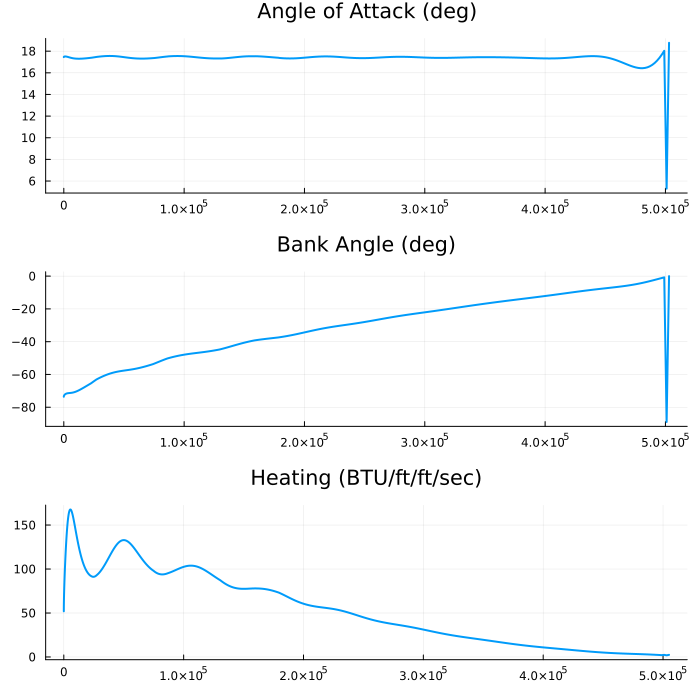

In [10]:
α = SpaceShuttleJMP[:α]
β = SpaceShuttleJMP[:β]
c₀ = 1.0672181
c₁ = -0.19213774e-1
c₂ = 0.21286289e-3
c₃ = -0.10117249e-5
ρ₀ = 0.002378
hᵣ = 23800.0
function q(h, v, a)
    ρ(h) = ρ₀ * exp(-h / hᵣ)
    qᵣ(h, v) = 17700 * √ρ(h) * (0.0001 * v)^3.07
    qₐ(a) = c₀ + c₁ * rad2deg(a) + c₂ * rad2deg(a)^2 + c₃ * rad2deg(a)^3
    # Aerodynamic heating on the vehicle wing leading edge
    return qₐ(a) * qᵣ(h, v)
end

plt_attack_angle = plot(
    ts[1:end-1],
    rad2deg.(value.(α)[1:end-1]);
    legend = nothing,
    title = "Angle of Attack (deg)",
)
plt_bank_angle = plot(
    ts[1:end-1],
    rad2deg.(value.(β)[1:end-1]);
    legend = nothing,
    title = "Bank Angle (deg)",
)
plt_heating = plot(
    ts,
    q.(value.(scaled_h) * 1e5, value.(scaled_v) * 1e4, value.(α));
    legend = nothing,
    title = "Heating (BTU/ft/ft/sec)",
)

plot(
    plt_attack_angle,
    plt_bank_angle,
    plt_heating;
    layout = grid(3, 1),
    linewidth = 2,
    size = (700, 700),
)

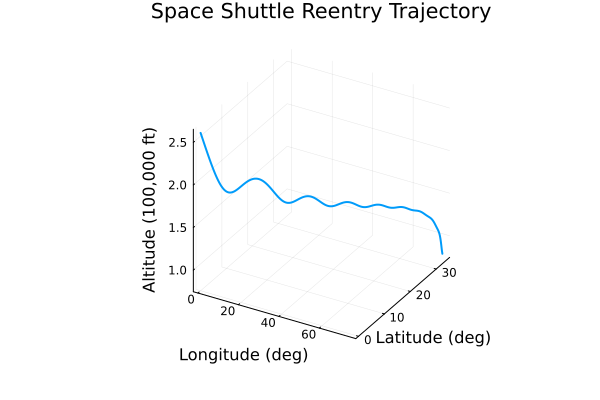

In [11]:
plot(
    rad2deg.(value.(ϕ)),
    rad2deg.(value.(θ)),
    value.(scaled_h);
    linewidth = 2,
    legend = nothing,
    title = "Space Shuttle Reentry Trajectory",
    xlabel = "Longitude (deg)",
    ylabel = "Latitude (deg)",
    zlabel = "Altitude (100,000 ft)",
)